# Metadata

* Title: Final Project for DS 5100
* Class: DS 5100
* Date: July 15, 2022
* Student Name: Eric Tria
* Student Net ID: emt4wf
* This URL: https://github.com/erictria/montecarlo-sim/blob/main/final-project-submission.ipynb
* GitHub Repo URL: https://github.com/erictria/montecarlo-sim

# The Monte Carlo Module

In [ ]:
import pandas as pd

class Die:
    '''
    Python class to replicate a die. A die has N faces, each with a defined weight. 
    Each face defaults to a weight of 1.0

    ATTRIBUTES:
    default_weight - float value for the default weight for each face
    __sides - private pandas dataframe containing the faces and weights of the die. Columns: ['face', 'weight']
    '''
    default_weight = 1.0

    def __init__(self, faces):
        self.__sides = pd.DataFrame({
            'face': faces,
            'weight': [self.default_weight] * len(faces)
        })
    
    def change_weight(self, face, weight):
        '''
        PURPOSE: changes the weight of a face of the die object

        INPUTS
        face - str or numeric; must match the current faces in the die
        weight - int or float
        '''
        if face in self.__sides['face'].values:
            if isinstance(weight, int) or isinstance(weight, float):
                float_weight = float(weight)
                self.__sides['weight'] = self.__sides[['face', 'weight']].apply(lambda x: float_weight if x['face'] == face else x['weight'], axis = 1)
            else:
                print('Error: Invalid weight value. Weight must be numeric.')
        else:
            print('Error: Invalid face value.')
    
    def roll(self, rolls = 1):
        '''
        PURPOSE: simulates rolling a die n times and returning the outcome

        INPUTS
        rolls - int

        OUTPUTS
        outcomes - list of str or numeric
        '''
        roll_result = self.__sides.sample(n = rolls, replace = True, weights = self.__sides.weight)
        outcomes = roll_result['face'].values.tolist()
        return outcomes
    
    def show_sides(self):
        '''
        PURPOSE: returns all the sides of the die.

        OUTPUTS
        sides - pandas dataframe
        '''
        return self.__sides

class Game:
    '''
    Python class to replicate a game of dice.
    A Game object has a list of Die objects.

    ATTRIBUTES:
    dice - list of Die objects
    faces - list of str or numeric
    __play_result - private pandas dataframe
    '''

    def __init__(self, dice):
        self.dice = dice
        self.faces = dice[0].show_sides().face.values.tolist()
    
    def play(self, rolls = 1):
        '''
        PURPOSE: Rolls each Die object n number of times
        Latest results are saved in a private pandas dataframe __play_result
        __play_result - index: ['roll_number']; columns: different die numbers; shape: M (rolls) rows x N (dice) columns

        INPUTS:
        rolls - int
        '''
        dice = self.dice
        roll_results = []
        for die_index, die in enumerate(dice):
            die_result = die.roll(rolls = rolls)
            for roll_index, roll_outcome in enumerate(die_result):
                roll_result = {
                    'roll_number': roll_index,
                    'die_number': die_index,
                    'face_value': roll_outcome
                }
                roll_results.append(roll_result)
        self.__play_result = pd.DataFrame(roll_results).pivot(index = 'roll_number', columns = 'die_number', values = 'face_value')
    
    def show_play_results(self, form = 'wide'):
        '''
        PURPOSE: Returns the private __play_result dataframe in eiher a wide or narrow format.
        Narrow - two-column index of 'roll_number' and 'die_number'; column for 'face_value'
        Wide - single column index of 'roll_number'; separate column for each die 'die_{n}'

        INPUTS:
        form - str; accepted values are 'wide' and 'narrow'; defaults to 'wide'

        OUTPUTS:
        __play_result - pandas dataframe
        '''
        if form == 'wide':
            return self.__play_result
        elif form == 'narrow':
            return self.__play_result.stack().to_frame('face_value')
        else:
            print('Error: Invalid form.')

class Analyzer:
    '''
    Python class that analyzes the results of a Game object.
    Jackpot - number of times a game resulted in all faces being identical
    Combo - distinct combination of faces rolled
    Face Counts per Roll - Number of times a given face is rolled in each event

    ATTRIBUTES:
    game - Game object
    jackpots - pandas dataframe
    combos = pandas dataframe
    face_counts = pandas dataframe
    '''

    def __init__(self, game):
        self.game = game
    
    def jackpot(self):
        '''
        PURPOSE: computes the number of times a game results with all faces being identical
        Tabular data is saved in the attribute 'jackpots'

        PROCESS:
        1. Group the play results of the game by roll number to get the unique count of resulting faces
        2. If the unique count is 1, tag 'jackpot' as 1. Otherwise, tag it as 0.
        3. The dataframe would have 'roll_number' as an index and 'jackpot' as a column.
        4. Get the sum of the 'jackpot' column to get the number of total jackpots.

        OUTPUTS:
        total_jackpots - int
        '''
        play_results = self.game.show_play_results(form = 'narrow')
        roll_unique_faces = play_results.groupby('roll_number')['face_value'].nunique()
        jackpot_results = []
        for i, r in roll_unique_faces.items():
            jackpot_results.append({
                'roll_number': i,
                'jackpot': 1 if r == 1 else 0
            })
        self.jackpots = pd.DataFrame(jackpot_results).set_index('roll_number')
        total_jackpots = self.jackpots.jackpot.sum().item()
        return total_jackpots
    
    def combo(self):
        '''
        PURPOSE: computes the distinct number of combinations rolled
        Tabular data is saved in the attribute 'combos'

        PROCESS:
        1. Group the play results of the game by roll number and combine all resulting faces into a sorted list 
            ['face_value_1', 'face_value_2', ...]
        2. Create a list of new column names based on the number of dice in the game.
        3. Create a dataframe using the lists from step 1 and the column names from step 2.
        4. Aggregate the new dataframe to get the total 'count' per combination
        '''
        play_results = self.game.show_play_results(form = 'narrow')
        grouped = play_results.groupby('roll_number')['face_value'].agg(lambda x: sorted(list(x)))

        num_dice = len(self.game.dice)
        index_names = []
        for i in range(0, num_dice):
            index_names.append('face_{}'.format(i + 1))
        
        combos_df = pd.DataFrame(grouped.values.tolist(), columns = index_names)
        combos_df['count'] = 1
        self.combos = combos_df.groupby(index_names).sum()
    
    def face_counts_per_roll(self):
        '''
        PURPOSE: computes the number of times a given face is rolled in each event
        Tabular data is saved in the attribute 'face_counts'

        PROCESS:
        1. Create a dataframe of all the possible face results per roll.
        2. Create a dataframe of the total count of each face result per roll.
        3. Merge the dataframes from step 1 and step 2 and fill the NaN values with 0s.
        '''
        faces = self.game.faces
        play_results = self.game.show_play_results(form = 'narrow').reset_index(level = 'die_number')

        all_faces = []
        for i in play_results.index.unique().tolist():
            for face in faces:
                all_faces.append({
                    'roll_number': i,
                    'face_value': face
                })
        all_faces_df = pd.DataFrame(all_faces).set_index('roll_number')

        face_counts_df = play_results.groupby(['roll_number', 'face_value'])\
            .count().reset_index(level = 'face_value')\
                .rename(columns = {'die_number': 'count'})
        
        self.face_counts = pd.merge(all_faces_df, face_counts_df, on = ['roll_number', 'face_value'], how = 'left')\
            .fillna(0).astype({'count': 'int32'})\
                .pivot(columns = 'face_value', values = 'count')

# Test Module

In [ ]:
import sys
sys.path.append('..')

from montecarlo import (
    Die,
    Game,
    Analyzer
)
import unittest

class DieTestSuite(unittest.TestCase):
    '''
    Test functions for testing the Die class.
    '''

    def test_1_change_weight(self):
        '''
        PURPOSE: tests the Die.change_weight() method

        OUTCOME:
        The row in the dataframe with the specified face should have the new weight value
        '''

        die = Die(faces = ['a', 'b', 'c'])
        new_weight = 3.0
        face_to_change = 'a'
        die.change_weight(face = face_to_change, weight = new_weight)

        sides = die.show_sides()
        changed_row = sides[(sides.face == face_to_change) & (sides.weight == new_weight)]

        self.assertTrue(len(changed_row) == 1, 'face weight not changed properly')
    
    def test_2_change_weight_invalid_inputs(self):
        '''
        PURPOSE: tests the invalid inputs for Die.change_weight() 

        OUTCOME:
        Weights of the Die should not change after passing invalid face and weight inputs
        '''

        faces = ['a', 'b', 'c']
        die = Die(faces = faces)
        invalid_new_weight = '3.0'
        new_weight = 3.0
        invalid_face_to_change = 'd'
        face_to_change = 'a'
        die.change_weight(face = invalid_face_to_change, weight = new_weight)
        die.change_weight(face = face_to_change, weight = invalid_new_weight)

        sides = die.show_sides()

        self.assertTrue(sides.weight.values.tolist() == [1.0] * len(faces), 'invalid inputs still changed weight of die face')
    
    def test_3_roll(self):
        '''
        PURPOSE: tests the Die.roll() method

        OUTCOMES:
        The unique resulting faces should be a subset of the initial list of faces AND
        The length of the resulting list should be equal to the total number of rolls
        '''

        faces = ['a', 'b', 'c']
        die = Die(faces = faces)
        rolls = 2
        roll_results = die.roll(rolls = rolls)

        is_subset = set(roll_results).issubset(set(faces))

        self.assertTrue(is_subset and (len(roll_results) == rolls), 'die did not roll properly')
    
    def test_4_show_sides(self):
        '''
        PURPOSE: tests the Die.show_sides() method

        OUTCOMES:
        The faces of the created Die object should be equal to the initial list of faces AND
        The weight of each side should be the default value of 1.0
        '''

        faces = ['a', 'b', 'c']
        default_weights = [1.0] * 3
        die = Die(faces = faces)
        sides = die.show_sides()
        side_faces = sides.face.values.tolist()
        side_weights = sides.weight.values.tolist()

        self.assertTrue(side_faces == faces and side_weights == default_weights, 'die sides not shown properly')

class GameTestSuite(unittest.TestCase):
    '''
    Test functions for testing the Game class.
    '''

    def test_1_play(self):
        '''
        PURPOSE: tests the Game.play() method

        OUTCOMES:
        The private attribute __play_result should not be accessible directly
        '''

        die = Die(faces = ['a', 'b', 'c'])
        game = Game(dice = [die] * 2)
        game.play()

        try:
            result = game.__play_result
            is_private = False
        except:
            is_private = True

        self.assertTrue(is_private, 'play_result attribute not set as private attribute')
    
    def test_2_show_play_results(self):
        '''
        PURPOSE: tests the Game.show_results() method

        OUTCOMES:
        The resulting wide dataframe should have a shape of M (rolls) rows x N (dice) columns
        '''

        die = Die(faces = ['a', 'b', 'c'])
        dice = [die] * 2
        game = Game(dice = dice)
        rolls = 5
        game.play(rolls = rolls)
        latest_results = game.show_play_results()

        self.assertTrue(latest_results.shape == (rolls, len(dice)), 'results returned an invalid play result')
    
    def test_3_show_play_results_inputs(self):
        '''
        PURPOSE: tests the valid inputs for the Game.show_results() method

        OUTCOMES:
        A 'wide' form dataframe should have 1 index AND
        A 'narrow' form dataframe should have 2 indices AND
        Any other form input should return None
        '''

        die = Die(faces = ['a', 'b', 'c'])
        game = Game(dice = [die] * 2)
        game.play()

        wide_play_results = game.show_play_results(form = 'wide')
        narrow_play_results = game.show_play_results(form = 'narrow')
        invalid_play_results = game.show_play_results(form = 'other string')

        self.assertTrue(len(wide_play_results.index.names) == 1 and len(narrow_play_results.index.names) == 2 and invalid_play_results is None, 'other')

class AnalyzerTestSuite(unittest.TestCase):
    '''
    Test functions for testing the Analyzer class.
    '''

    def test_1_jackpot(self):
        '''
        PURPOSE: tests the Analyzer.jackpot() method

        OUTPUTS:
        The jackpot method should return an int that is greater than or equal to 0
        '''

        die = Die(faces = ['a', 'b', 'c'])
        game = Game(dice = [die] * 2)
        game.play()
        analyzer = Analyzer(game = game)
        jackpot = analyzer.jackpot()

        self.assertTrue(isinstance(jackpot, int) and jackpot >= 0, 'jackpot returned an invalid value')
    
    def test_2_combo(self):
        '''
        PURPOSE: tests the Analyzer.combo() method

        OUTCOMES:
        The sum of the 'count' column should be equal to the total number of rolls AND
        The number of indices of the resulting dataframe should be equal to the number of dice
        '''

        faces = ['a', 'b', 'c']
        die = Die(faces = faces)
        dice = [die] * 5
        game = Game(dice = dice)
        rolls = 2
        game.play(rolls = rolls)
        analyzer = Analyzer(game)

        analyzer.combo()
        combos = analyzer.combos

        self.assertTrue(combos['count'].sum().item() == rolls and len(combos.index.names) == len(dice), 'combos attribute has an invalid value')
    
    def test_3_face_counts_per_roll(self):
        '''
        PURPOSE: tests the Analyzer.face_counts_per_roll() method

        OUTCOMES:
        The total sum of all face counts should be equal to the number of rolls x the number of dice AND
        The shape of the resulting dataframe should be M (rolls) rows x N (faces) columns
        '''

        faces = ['a', 'b', 'c']
        die = Die(faces = faces)
        dice = [die] * 5
        game = Game(dice = dice)
        rolls = 2
        game.play(rolls = rolls)
        analyzer = Analyzer(game)

        analyzer.face_counts_per_roll()
        face_counts = analyzer.face_counts
        self.assertTrue(face_counts.sum().sum().item() == (rolls * len(dice)) and face_counts.shape == (rolls, len(faces)), 'face_counts attribute has an invalid value')

if __name__ == '__main__':
    unittest.main(verbosity = 3)

# Test Results

```
test_1_jackpot (__main__.AnalyzerTestSuite)
PURPOSE: tests the Analyzer.jackpot() method ... ok
test_2_combo (__main__.AnalyzerTestSuite)
PURPOSE: tests the Analyzer.combo() method ... ok
test_3_face_counts_per_roll (__main__.AnalyzerTestSuite)
PURPOSE: tests the Analyzer.face_counts_per_roll() method ... ok
test_1_change_weight (__main__.DieTestSuite)
PURPOSE: tests the Die.change_weight() method ... ok
test_2_change_weight_invalid_inputs (__main__.DieTestSuite)
PURPOSE: tests the invalid inputs for Die.change_weight() ... ok
test_3_roll (__main__.DieTestSuite)
PURPOSE: tests the Die.roll() method ... ok
test_4_show_sides (__main__.DieTestSuite)
PURPOSE: tests the Die.show_sides() method ... ok
test_1_play (__main__.GameTestSuite)
PURPOSE: tests the Game.play() method ... ok
test_2_show_play_results (__main__.GameTestSuite)
PURPOSE: tests the Game.show_results() method ... ok
test_3_show_play_results_inputs (__main__.GameTestSuite)
PURPOSE: tests the valid inputs for the Game.show_results() method ... ok

----------------------------------------------------------------------
Ran 10 tests in 0.036s

OK
```

# Scenarios

Code blocks with your scenarios and their outputs. 

These should have appropriate import statements even though the code is now in the same notebook as the classes it calls. 

In [ ]:
import pandas as pd
from montecarlo.montecarlo import (
    Die,
    Game,
    Analyzer
)

## Scenario 1

Relative Frequenct of Jackpots


<AxesSubplot:xlabel='game'>

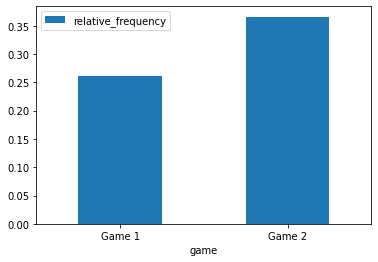

In [3]:
faces = ['H', 'T']
# Fair coin uses the default weight of 1 for all faces
fair_coin = Die(faces = faces)

# Unfair coin has one face with a weight of 5
unfair_coin = Die(faces = faces)
unfair_coin.change_weight(face = 'H', weight = 5)

total_rolls = 1000

# A Game that uses 3 fair dice. Rolls 1000 times
game_1 = Game(dice = [fair_coin] * 3)
game_1.play(rolls = total_rolls)

# A Game that uses 2 unfair dice and 1 fair dice. Rolls 1000 times
game_2 = Game(dice = ([unfair_coin] * 2) + [fair_coin])
game_2.play(rolls = total_rolls)

# Use an Analyzer for each Game to compute the relative frequency of jackpots – getting either all Hs or all Ts
# Relative frequency is computed as the number of jackpots over the total number of rolls
analyzer_1 = Analyzer(game = game_1)
game_1_jackpot = analyzer_1.jackpot()
game_1_relative_frequency = game_1_jackpot / total_rolls

analyzer_2 = Analyzer(game = game_2)
game_2_jackpot = analyzer_2.jackpot()
game_2_relative_frequency = game_2_jackpot / total_rolls

# Compare the results in a bar chart
print('Relative Frequenct of Jackpots')
results_df = pd.DataFrame({
    'game': ['Game 1', 'Game 2'],
    'relative_frequency': [game_1_relative_frequency, game_2_relative_frequency]
})
results_df.plot.bar(x = 'game', y = 'relative_frequency', rot = 0)

## Scenario 2

Relative Frequenct of Jackpots


<AxesSubplot:xlabel='game'>

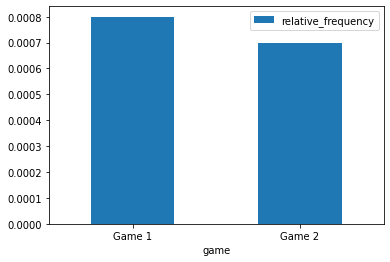

In [5]:
faces = range(1, 7)
# Fair die uses the default weight of 1 for all faces
fair_die = Die(faces = faces)

# Unfair die type 1 with face 6 having a weight of 5
unfair_die_type_1 = Die(faces = faces)
unfair_die_type_1.change_weight(face = 6, weight = 5)

# Unfair die type 2 with face 1 having a weight of 5
unfair_die_type_2 = Die(faces = faces)
unfair_die_type_2.change_weight(face = 1, weight = 5)

total_rolls = 10000

# A Game that uses 5 fair dice. Rolls 10000 times
game_1 = Game(dice = [fair_die] * 5)
game_1.play(rolls = total_rolls)

# A Game that uses 2 fair dice, 2 type 1 unfair dice, and 1 type 2 unfair die. Rolls 10000 times
game_2 = Game(dice = ([unfair_die_type_1] * 2) + [unfair_die_type_2] + ([fair_die] * 2))
game_2.play(rolls = total_rolls)

# Use an Analyzer for each Game to compute the relative frequency of jackpots
# Relative frequency is computed as the number of jackpots over the total number of rolls
analyzer_1 = Analyzer(game = game_1)
game_1_jackpot = analyzer_1.jackpot()
game_1_relative_frequency = game_1_jackpot / total_rolls

analyzer_2 = Analyzer(game = game_2)
game_2_jackpot = analyzer_2.jackpot()
game_2_relative_frequency = game_2_jackpot / total_rolls

# Compare the results in a bar chart
print('Relative Frequenct of Jackpots')
results_df = pd.DataFrame({
    'game': ['Game 1', 'Game 2'],
    'relative_frequency': [game_1_relative_frequency, game_2_relative_frequency]
})
results_df.plot.bar(x = 'game', y = 'relative_frequency', rot = 0)

## Scenario 3

In [9]:
# A die with all the letters of the alphabet using weights based on their frequency of usage
alphabet_reference = pd.DataFrame(
    [['A', 8.4966],
    ['B', 2.0720],
    ['C', 4.5388],
    ['D', 3.3844],
    ['E', 11.1607],
    ['F', 1.8121],
    ['G', 2.4705],
    ['H', 3.0034],
    ['I', 7.5448],
    ['J', 0.1965],
    ['K', 1.1016],
    ['L', 5.4893],
    ['M', 3.0129],
    ['N', 6.6544],
    ['O', 7.1635],
    ['P', 3.1671],
    ['Q', 0.1962],
    ['R', 7.5809],
    ['S', 5.7351],
    ['T', 6.9509],
    ['U', 3.6308],
    ['V', 1.0074],
    ['W', 1.2899],
    ['X', 0.2902],
    ['Y', 1.7779],
    ['Z', 0.2722]], 
    columns = ['face', 'weight']
)
alphabet_die = Die(faces = alphabet_reference.face.values.tolist())
for a in alphabet_reference.to_dict('records'):
    alphabet_die.change_weight(face = a['face'], weight = a['weight'])

# A Game with 5 of these alphabet dice. Rolls 1000 times
total_rolls = 1000
game = Game(dice = [alphabet_die] * 5)
game.play(rolls = total_rolls)
game_results = game.show_play_results()
game_results

die_number,0,1,2,3,4
roll_number,,,,,
0,O,E,U,D,L
1,I,H,E,E,B
2,T,E,L,I,R
3,A,A,K,T,R
4,E,S,E,O,O
...,...,...,...,...,...
995,E,C,T,A,C
996,E,N,H,A,W
997,T,L,A,E,R


In [11]:
# Based on an eye test, count how many combos look like actual words
# Some results resembled words, meaning they are 1 or 2 letters off from being actual words
actual_words = 5
resembled_words = 15

relative_frequency = (actual_words + resembled_words) / total_rolls
print('Relative Frequency:', relative_frequency)

Relative Frequency: 0.02


To get a better result of relative frequency, 
the [english-words](https://pypi.org/project/english-words/) library was used to detect 
if the words generated are in English:

In [14]:
from english_words import english_words_set

game_results['word'] = game_results[[0, 1, 2, 3, 4]].agg(''.join, axis = 1)
game_results['is_english'] = game_results['word']\
    .apply(lambda x: 1 if x.lower() in english_words_set else 0)
print(game_results[game_results['is_english'] == 1])

actual_words = game_results['is_english'].sum().item()
actual_relative_frequency = actual_words / 1000
print('Actual Relative Frequency:', actual_relative_frequency)

             0  1  2  3  4   word  is_english
roll_number                                  
62           T  E  R  S  E  TERSE           1
115          R  O  D  E  O  RODEO           1
373          S  T  O  R  E  STORE           1
Actual Relative Frequency: 0.003


# Directory Listing

A code block that executes the following bash command: 

```bash
!ls -lRF -o
```

In [2]:
!ls -lRF -o

total 272
-rw-r--r--  1 erictria   1065 Jul  9 17:08 LICENSE
-rw-r--r--  1 erictria   6300 Jul 14 09:33 README.md
-rw-r--r--  1 erictria  58613 Jul 14 09:23 final-project-submission.ipynb
drwxr-xr-x  5 erictria    160 Jul 14 09:35 montecarlo/
-rw-r--r--  1 erictria  59566 Jul 13 14:19 montecarlo_demo.ipynb
-rw-r--r--  1 erictria    409 Jul 14 09:19 setup.py

./montecarlo:
total 32
-rw-r--r--  1 erictria    17 Jul 12 20:50 __init__.py
-rw-r--r--  1 erictria  8998 Jul 14 09:31 montecarlo.py
drwxr-xr-x  4 erictria   128 Jul 13 21:34 tests/

./montecarlo/tests:
total 24
-rw-r--r--  1 erictria  6981 Jul 13 21:36 montecarlo_test.py
-rw-r--r--  1 erictria  1120 Jul 13 21:36 montecarlo_test_results.txt


# Installation Output Listing
    
A code block that executes the code to install your your package and outputs a successful installation.

In [3]:
!pip install -e .

Obtaining file:///Users/erictria/Documents/UVA/Summer/DS5100/montecarlo-sim
  Running setup.py develop for montecarlo
